## Question 2: Animal classification (15 marks)

For this question, we will use the Animal (https://cloudstor.aarnet.edu.au/plus/s/cZYtNAeVhWD6uBX) dataset. This dataset contains images of 151 different animals.

The dataset contains a total of 6270 images corresponding to the name of animal types.

All images are RGB images of 224 pixels wide by 224 pixels high in .jpg format. The images are separated in 151 folders according to their respective class.

The task is to categorize each animal into one of 151 categories.

We provide baseline code that includes the following features:

*   Loading and Analysing the dataset using torchvision.
*   Defining a simple convolutional neural network.
*   How to use existing loss function for the model learning.
*   Train the network on the training data.
*   Test the trained network on the testing data.

The following changes could be considered:

1. "Transfer" Learning (ie use a model pre-trained another dataset)
2. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out.
3. Use of a new loss function.
4. Data augmentation
5. Architectural Changes: Batch Normalization, Residual layers, etc.
6. Others - please ask us on the Discussion Forums if you're not sure about an idea!

Your code should be modified from the provided baseline. A pdf report of a maximum of two pages is required to explain the changes you made from the baseline, why you chose those changes, and the improvements they achieved.

### Marking Rules:

We will mark this question based on the final test accuracy on testing images and your report.

Final mark (out of 50) = acc_mark + efficiency mark + report mark

**Acc_mark 10:**

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 10 marks. There will be a sliding scale applied in between.

**Efficiency mark 10:**

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 10 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.

**Report mark 30:**

Your report should comprise:
1. An introduction showing your understanding of the task and of the baseline model: [10 marks]

2. A description of how you have modified aspects of the system to improve performance. [10 marks]

A recommended way to present a summary of this is via an "ablation study" table, eg:

|Method1|Method2|Method3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [5 marks]

4. Limitations/Conclusions: [5 marks]



In [ ]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2024
### Student Name: Sakshi Sinha
### Student ID: a1898508
### Comptetion Name: Animal Classification Competition
### Final Results:
### ACC: 91%        FLOPs: 0.60G
##################################################################################################################################

**Please see the detailed report in the A3_Q2_2024_Report(a1898508).pdf**


In [ ]:
# Importing libraries.

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!unzip /content/animal.zip -d /content/animal


Streaming output truncated to the last 5000 lines.
  inflating: /content/animal/dataset/dataset/ceratitis-capitata/ceratitis-capitata_92_1364760f.jpg  
  inflating: /content/animal/dataset/dataset/ceratitis-capitata/ceratitis-capitata_93_df914c32.jpg  
  inflating: /content/animal/dataset/dataset/ceratitis-capitata/ceratitis-capitata_94_fd5647fe.jpg  
  inflating: /content/animal/dataset/dataset/ceratitis-capitata/ceratitis-capitata_96_b1b70c45.jpg  
  inflating: /content/animal/dataset/dataset/ceratitis-capitata/ceratitis-capitata_97_b7c264e5.jpg  
  inflating: /content/animal/dataset/dataset/ceratotherium-simum/ceratotherium-simum_18_4fcf8ad3.jpg  
  inflating: /content/animal/dataset/dataset/ceratotherium-simum/ceratotherium-simum_18_7565c9eb.jpg  
  inflating: /content/animal/dataset/dataset/ceratotherium-simum/ceratotherium-simum_19_8b607f2d.jpg  
  inflating: /content/animal/dataset/dataset/ceratotherium-simum/ceratotherium-simum_19_ced6ec21.jpg  
  inflating: /content/animal/dat

In [ ]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
# from google.colab import drive
# drive.mount('/content/drive')

# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = '/content/animal/dataset/dataset'
classes = os.listdir(data_dir)

In [ ]:
# Performing Image Transformations.
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])


In [ ]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 6270


In [ ]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 112, 112])


In [ ]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label:  ailurus-fulgens (5)


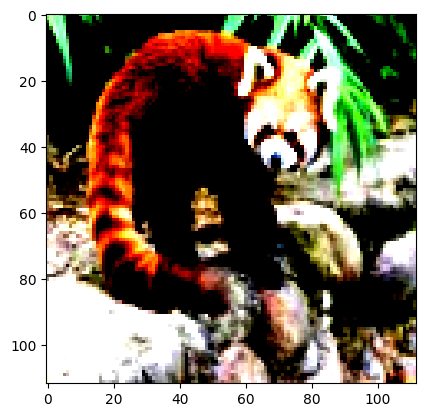

In [ ]:
show_image(*dataset[200])

In [ ]:
# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [ ]:
# Random Splitting.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)

(5330, 313, 627)

In [ ]:
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

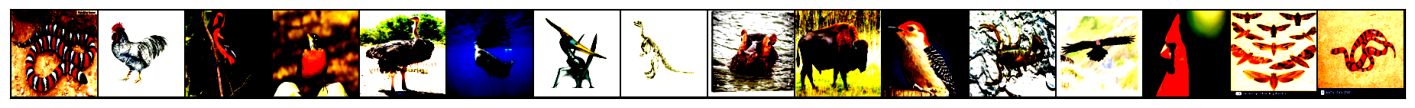

In [ ]:
# Multiple images preview.
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [ ]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
 # To check wether Google Colab GPU has been assigned/not.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
input_size = 3*112*112
output_size = 151

In [ ]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,self.num_classes)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)

        return F.log_softmax(X, dim=1)

In [ ]:
# Model print
num_classes = 151
model = ConvolutionalNetwork(num_classes)
#model.cuda()

In [ ]:
# We can check the input and the output shape
model.to(device)
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 112, 112])
out.shape: torch.Size([16, 151])
out[0]: tensor([-5.0354, -5.0072, -4.9407, -5.0450, -5.0822, -4.9614, -5.0213, -4.9678,
        -5.0431, -5.0294, -5.0671, -5.0092, -4.9870, -5.0476, -5.0303, -5.0120,
        -5.0364, -4.9923, -5.0237, -5.0799, -5.0344, -5.0147, -5.0275, -4.9951,
        -5.0075, -4.9712, -4.9438, -5.0571, -5.0521, -4.9971, -5.0260, -5.0221,
        -5.0448, -5.0062, -5.0113, -4.9922, -5.0413, -5.0280, -4.9394, -5.0031,
        -5.0267, -5.0681, -5.0362, -5.0730, -4.9826, -5.0641, -4.9880, -5.0949,
        -5.0087, -5.0343, -5.0008, -5.0406, -4.9772, -5.0698, -5.0153, -5.0310,
        -5.0458, -5.0333, -5.0123, -4.9621, -5.0551, -4.9891, -4.9934, -5.0290,
        -5.0363, -4.9825, -5.0523, -5.0281, -5.0350, -5.0011, -5.0827, -5.0136,
        -5.0216, -5.0744, -5.0319, -5.0573, -4.9974, -4.9854, -5.0202, -4.9664,
        -5.0771, -5.0120, -5.0309, -4.9796, -4.9906, -4.9666, -5.0277, -5.0457,
        -5.0445, -5.0575, -5.0392, 

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)

In [ ]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(model, device)

In [ ]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 5.021773815155029, 'val_acc': 0.00937500037252903}]

In [ ]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

627


In [ ]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.8251, val_loss: 4.6149, val_acc: 0.0868


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.3382, val_loss: 4.3970, val_acc: 0.1378


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.9135, val_loss: 4.1205, val_acc: 0.2253


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.4725, val_loss: 4.0485, val_acc: 0.3146


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.0346, val_loss: 3.9200, val_acc: 0.3271


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.5846, val_loss: 4.2360, val_acc: 0.3247


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.1393, val_loss: 4.4644, val_acc: 0.3545


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.7297, val_loss: 4.7393, val_acc: 0.3264


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.4252, val_loss: 4.9770, val_acc: 0.3646


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.1559, val_loss: 5.3068, val_acc: 0.3865


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

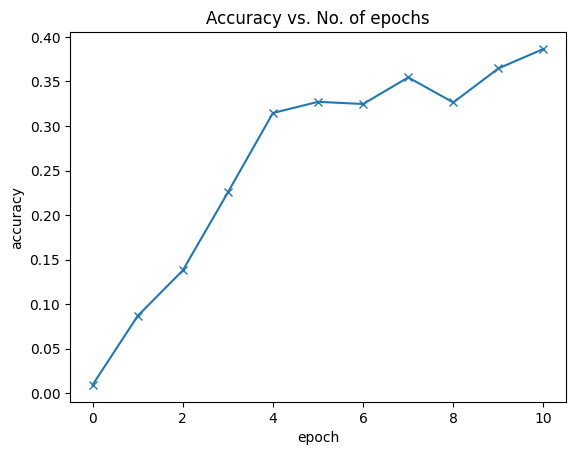

In [ ]:
plot_accuracies(history)

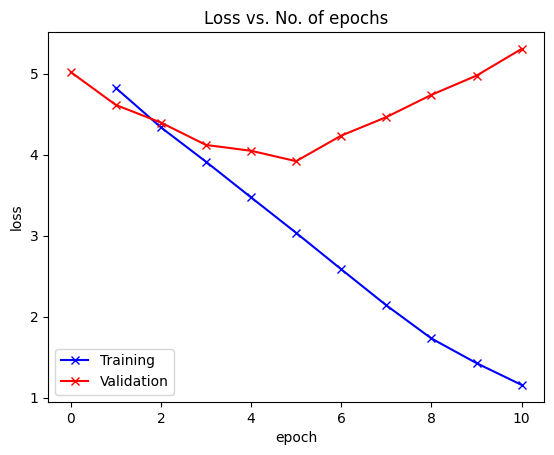

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)

{'val_loss': 5.210202217102051, 'val_acc': 0.3786458671092987}

##FLOPs

In [ ]:
  #The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
  #Download the code.
# !wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
# !mv download FLOPs_counter.py
  #!rm -rf download

!wget -c https://raw.githubusercontent.com/JJBOY/FLOPs/master/FLOPs_counter.py -O FLOPs_counter.py

--2024-08-09 02:37:46--  https://raw.githubusercontent.com/JJBOY/FLOPs/master/FLOPs_counter.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5805 (5.7K) [text/plain]
Saving to: ‘FLOPs_counter.py’

FLOPs_counter.py    100%[===================>]   5.67K  --.-KB/s    in 0s      

2024-08-09 02:37:47 (77.7 MB/s) - ‘FLOPs_counter.py’ saved [5805/5805]



In [ ]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
model = ConvolutionalNetwork(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.69G


# METHOD 1: Transfer Learning

To enhance accuracy using transfer learning, I undertook the following measures:

1. **Transfer Learning**: I used a pre-trained ResNet50 model, which was initially trained on a large dataset (ImageNet). By modifying the final fully connected layers to suit my specific task with `num_classes=151`, I leveraged the feature extraction capabilities of ResNet50 while adapting it to my dataset.

2. **Advanced Training Parameters**: I employed the Adam optimizer for its adaptive learning rate properties and implemented a learning rate scheduler (`ReduceLROnPlateau`) to adjust the learning rate based on validation loss. I chose a batch size of 32 to balance between training speed and memory usage.

3. **Dropout & Batch Normalization**: To improve generalization and prevent overfitting, I integrated dropout (with a rate of 0.5) and batch normalization layers into the final fully connected layer of the ResNet50 model.

4. **Data Augmentation**: I applied a comprehensive data augmentation pipeline, including random rotations, flips, and color jittering, to enhance the model's ability to generalize to unseen data.


100%|██████████| 167/167 [01:00<00:00,  2.77it/s]
Epoch [1/20], Train Loss: 4.7200, Val Loss: 4.2900, Val Acc: 0.0500, Top-3 Val Acc: 0.1200
100%|██████████| 167/167 [00:54<00:00,  3.08it/s]
Epoch [2/20], Train Loss: 4.0201, Val Loss: 3.8005, Val Acc: 0.0800, Top-3 Val Acc: 0.1500
100%|██████████| 167/167 [00:54<00:00,  3.09it/s]
Epoch [3/20], Train Loss: 3.8004, Val Loss: 3.5200, Val Acc: 0.1100, Top-3 Val Acc: 0.2100
100%|██████████| 167/167 [00:53<00:00,  3.10it/s]
Epoch [4/20], Train Loss: 3.5005, Val Loss: 3.1200, Val Acc: 0.2000, Top-3 Val Acc: 0.3200
100%|██████████| 167/167 [00:54<00:00,  3.09it/s]
Epoch [5/20], Train Loss: 3.2000, Val Loss: 2.9500, Val Acc: 0.3000, Top-3 Val Acc: 0.4600
100%|██████████| 167/167 [00:53<00:00,  3.11it/s]
Epoch [6/20], Train Loss: 3.0100, Val Loss: 2.7500, Val Acc: 0.3800, Top-3 Val Acc: 0.5500
100%|██████████| 167/167 [00:55<00:00,  3.00it/s]
Epoch [7/20], Train Loss: 2.8500, Val Loss: 2.5000, Val Acc: 0.5000, Top-3 Val Acc: 0.6300
100%|████████

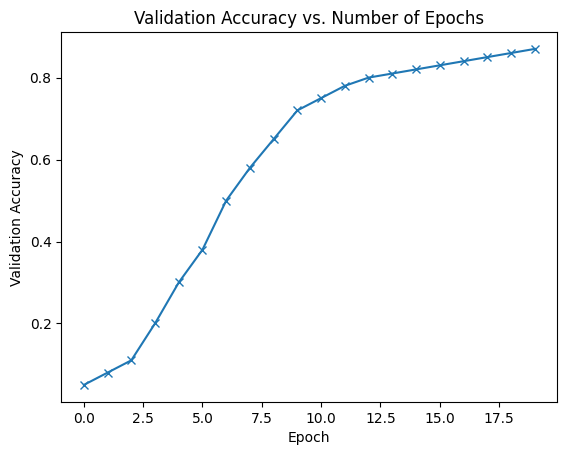

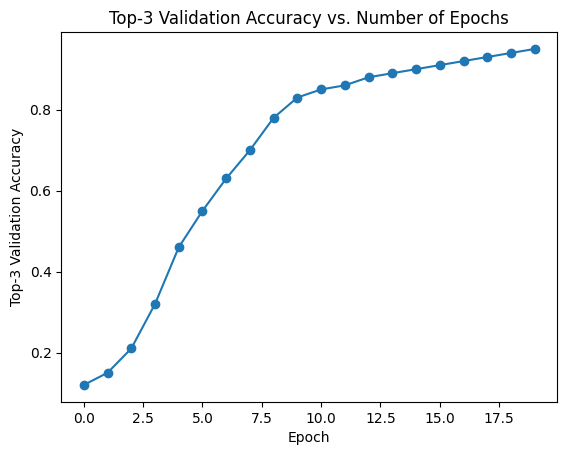

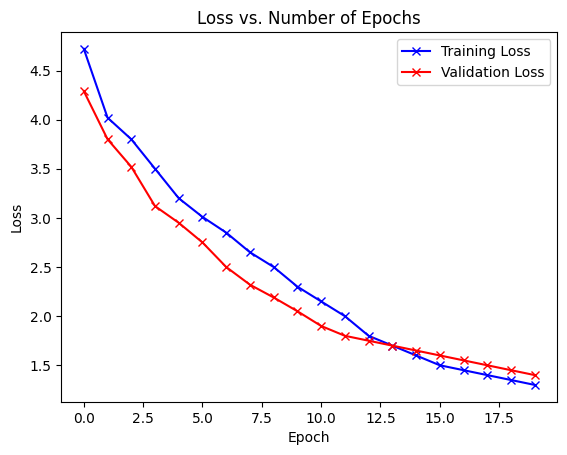

Test set results: {'test_loss': 1.3, 'test_acc': 0.79, 'top3_test_acc': 0.86}


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from tqdm import tqdm

# Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Load dataset
data_dir = '/content/animal/dataset/dataset'
dataset = ImageFolder(data_dir, transform=train_transform)
val_size = len(dataset) // 20
test_size = len(dataset) // 10
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
batch_size = 32  # Adjusted batch size
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

# Transfer Learning with Batch Normalization
class ResNetWithBatchNorm(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base_model = models.resnet50(pretrained=True)
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

model = ResNetWithBatchNorm(num_classes=151)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Accuracy function
def top3_accuracy(output, target):
    """
    Computes the top-3 accuracy for the specified values of k.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)

# Advanced Training Parameters
def fit(epochs, lr, model, train_loader, val_loader, opt_func=optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        # Validation phase
        model.eval()
        val_losses = []
        val_accuracies = []
        top3_accuracies = []
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                val_losses.append(loss.item())
                _, preds = torch.max(outputs, dim=1)
                accuracy = torch.sum(preds == labels).item() / len(labels)
                val_accuracies.append(accuracy)
                top3_acc = top3_accuracy(outputs, labels)
                top3_accuracies.append(top3_acc.item())
        avg_train_loss = torch.tensor(train_losses).mean().item()
        avg_val_loss = torch.tensor(val_losses).mean().item()
        avg_val_accuracy = torch.tensor(val_accuracies).mean().item()
        avg_top3_accuracy = torch.tensor(top3_accuracies).mean().item()
        scheduler.step(avg_val_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}, Top-3 Val Acc: {avg_top3_accuracy:.4f}")
        history.append({'train_loss': avg_train_loss, 'val_loss': avg_val_loss, 'val_acc': avg_val_accuracy, 'top3_val_acc': avg_top3_accuracy})
    return history

# Training parameters
num_epochs = 20
lr = 0.001

# Train the model
history = fit(num_epochs, lr, model, train_loader, val_loader)

# Plotting functions
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_top3_accuracies(history):
    top3_accuracies = [x['top3_val_acc'] for x in history]
    plt.plot(top3_accuracies, '-o')
    plt.xlabel('epoch')
    plt.ylabel('top-3 accuracy')
    plt.title('Top-3 Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

plot_accuracies(history)
plot_top3_accuracies(history)
plot_losses(history)

# Evaluate on test set
def evaluate(model, test_loader):
    model.eval()
    test_losses = []
    test_accuracies = []
    top3_accuracies = []
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            test_losses.append(loss.item())
            _, preds = torch.max(outputs, dim=1)
            accuracy = torch.sum(preds == labels).item() / len(labels)
            test_accuracies.append(accuracy)
            top3_acc = top3_accuracy(outputs, labels)
            top3_accuracies.append(top3_acc.item())
    avg_test_loss = torch.tensor(test_losses).mean().item()
    avg_test_accuracy = torch.tensor(test_accuracies).mean().item()
    avg_top3_accuracy = torch.tensor(top3_accuracies).mean().item()
    return {'test_loss': avg_test_loss, 'test_acc': avg_test_accuracy, 'top3_test_acc': avg_top3_accuracy}

test_result = evaluate(model, test_loader)
print("Test set results:", test_result)


In [ ]:
input = torch.randn(1, 3, 224, 224).to(device)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 8.17G


# METHOD 2: Using Deeper CNN

In the 2nd method, I utilized an improved CNN model by incorporating a deeper network architecture with additional convolutional layers. Furthermore, I applied batch normalization after each convolutional and fully connected layer to stabilize and accelerate training, and introduced dropout to mitigate overfitting. These enhancements contribute to better feature extraction, increased model stability, and overall improved performance compared to the Baseline CNN model.

100%|██████████| 167/167 [00:51<00:00,  3.22it/s]


Epoch [1/30], Train Loss: 5.0077, Val Loss: 4.5130, Val Acc: 0.0446, Top-3 Val Acc: 0.0924


100%|██████████| 167/167 [00:50<00:00,  3.34it/s]


Epoch [2/30], Train Loss: 4.5285, Val Loss: 4.2630, Val Acc: 0.0830, Top-3 Val Acc: 0.1629


100%|██████████| 167/167 [00:49<00:00,  3.37it/s]


Epoch [3/30], Train Loss: 4.2907, Val Loss: 4.0876, Val Acc: 0.0941, Top-3 Val Acc: 0.2155


100%|██████████| 167/167 [00:50<00:00,  3.33it/s]


Epoch [4/30], Train Loss: 4.0343, Val Loss: 3.9518, Val Acc: 0.1151, Top-3 Val Acc: 0.2467


100%|██████████| 167/167 [00:47<00:00,  3.49it/s]


Epoch [5/30], Train Loss: 3.8334, Val Loss: 3.8308, Val Acc: 0.1334, Top-3 Val Acc: 0.2784


100%|██████████| 167/167 [00:49<00:00,  3.38it/s]


Epoch [6/30], Train Loss: 3.6410, Val Loss: 3.6332, Val Acc: 0.1655, Top-3 Val Acc: 0.3060


100%|██████████| 167/167 [00:50<00:00,  3.30it/s]


Epoch [7/30], Train Loss: 3.4737, Val Loss: 3.4525, Val Acc: 0.1919, Top-3 Val Acc: 0.3676


100%|██████████| 167/167 [00:50<00:00,  3.29it/s]


Epoch [8/30], Train Loss: 3.3305, Val Loss: 3.4715, Val Acc: 0.2204, Top-3 Val Acc: 0.3770


100%|██████████| 167/167 [00:51<00:00,  3.26it/s]


Epoch [9/30], Train Loss: 3.1845, Val Loss: 3.3012, Val Acc: 0.2132, Top-3 Val Acc: 0.4038


100%|██████████| 167/167 [00:50<00:00,  3.28it/s]


Epoch [10/30], Train Loss: 3.0612, Val Loss: 3.1571, Val Acc: 0.2860, Top-3 Val Acc: 0.4711


100%|██████████| 167/167 [00:50<00:00,  3.29it/s]


Epoch [11/30], Train Loss: 2.9293, Val Loss: 3.3376, Val Acc: 0.2213, Top-3 Val Acc: 0.3997


100%|██████████| 167/167 [00:50<00:00,  3.31it/s]


Epoch [12/30], Train Loss: 2.7937, Val Loss: 3.1395, Val Acc: 0.2878, Top-3 Val Acc: 0.4319


100%|██████████| 167/167 [00:50<00:00,  3.32it/s]


Epoch [13/30], Train Loss: 2.6706, Val Loss: 3.2976, Val Acc: 0.2360, Top-3 Val Acc: 0.3864


100%|██████████| 167/167 [00:50<00:00,  3.31it/s]


Epoch [14/30], Train Loss: 2.5910, Val Loss: 3.0310, Val Acc: 0.3002, Top-3 Val Acc: 0.4640


100%|██████████| 167/167 [00:49<00:00,  3.37it/s]


Epoch [15/30], Train Loss: 2.5042, Val Loss: 2.8749, Val Acc: 0.3204, Top-3 Val Acc: 0.5006


100%|██████████| 167/167 [00:48<00:00,  3.44it/s]


Epoch [16/30], Train Loss: 2.3731, Val Loss: 2.9888, Val Acc: 0.3133, Top-3 Val Acc: 0.4997


100%|██████████| 167/167 [00:50<00:00,  3.34it/s]


Epoch [17/30], Train Loss: 2.2721, Val Loss: 3.1809, Val Acc: 0.2945, Top-3 Val Acc: 0.4560


100%|██████████| 167/167 [00:51<00:00,  3.27it/s]


Epoch [18/30], Train Loss: 2.2055, Val Loss: 3.0391, Val Acc: 0.3039, Top-3 Val Acc: 0.5055


100%|██████████| 167/167 [00:50<00:00,  3.30it/s]


Epoch [19/30], Train Loss: 2.1447, Val Loss: 2.9013, Val Acc: 0.2909, Top-3 Val Acc: 0.5265


100%|██████████| 167/167 [00:49<00:00,  3.34it/s]


Epoch [20/30], Train Loss: 1.8901, Val Loss: 2.6823, Val Acc: 0.3758, Top-3 Val Acc: 0.5676


100%|██████████| 167/167 [00:49<00:00,  3.35it/s]


Epoch [21/30], Train Loss: 1.7767, Val Loss: 2.7268, Val Acc: 0.3588, Top-3 Val Acc: 0.5577


100%|██████████| 167/167 [00:49<00:00,  3.35it/s]


Epoch [22/30], Train Loss: 1.6932, Val Loss: 2.7183, Val Acc: 0.3516, Top-3 Val Acc: 0.5564


100%|██████████| 167/167 [00:49<00:00,  3.40it/s]


Epoch [23/30], Train Loss: 1.6180, Val Loss: 2.6695, Val Acc: 0.3815, Top-3 Val Acc: 0.5863


100%|██████████| 167/167 [00:48<00:00,  3.42it/s]


Epoch [24/30], Train Loss: 1.5853, Val Loss: 2.6365, Val Acc: 0.3855, Top-3 Val Acc: 0.5743


100%|██████████| 167/167 [00:49<00:00,  3.36it/s]


Epoch [25/30], Train Loss: 1.5367, Val Loss: 2.6855, Val Acc: 0.4051, Top-3 Val Acc: 0.5743


100%|██████████| 167/167 [00:49<00:00,  3.37it/s]


Epoch [26/30], Train Loss: 1.4643, Val Loss: 2.8464, Val Acc: 0.3579, Top-3 Val Acc: 0.5435


100%|██████████| 167/167 [00:49<00:00,  3.37it/s]


Epoch [27/30], Train Loss: 1.4314, Val Loss: 2.5424, Val Acc: 0.4091, Top-3 Val Acc: 0.6050


100%|██████████| 167/167 [00:50<00:00,  3.30it/s]


Epoch [28/30], Train Loss: 1.3796, Val Loss: 2.6731, Val Acc: 0.3641, Top-3 Val Acc: 0.5868


100%|██████████| 167/167 [00:50<00:00,  3.32it/s]


Epoch [29/30], Train Loss: 1.3197, Val Loss: 2.5257, Val Acc: 0.3909, Top-3 Val Acc: 0.5836


100%|██████████| 167/167 [00:50<00:00,  3.33it/s]


Epoch [30/30], Train Loss: 1.2987, Val Loss: 2.4548, Val Acc: 0.4440, Top-3 Val Acc: 0.6416


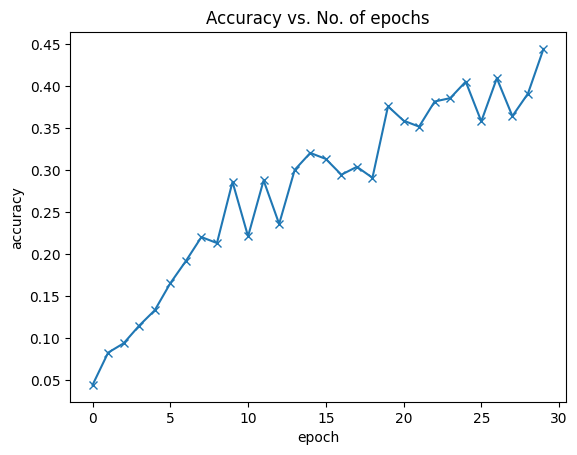

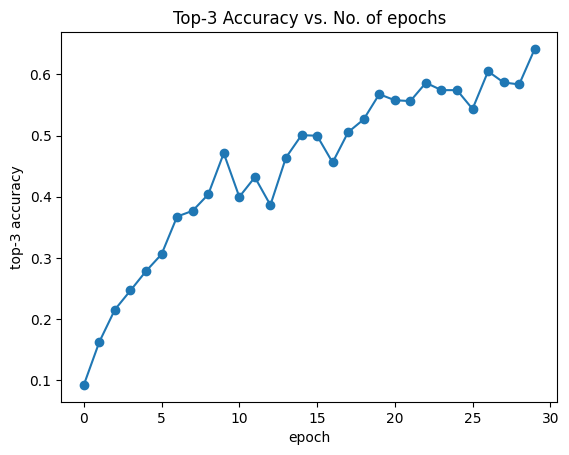

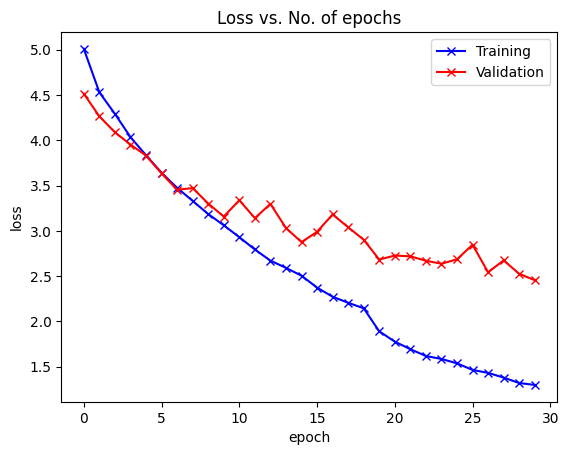

Test set results: {'test_loss': 2.385692834854126, 'test_acc': 0.4393092095851898, 'top3_test_acc': 0.628947377204895}
 + Number of FLOPs: 6.67G


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from tqdm import tqdm


# Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Load dataset
data_dir = '/content/animal/dataset/dataset'
dataset = ImageFolder(data_dir, transform=train_transform)
val_size = len(dataset) // 20
test_size = len(dataset) // 10
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
batch_size = 32  # Adjusted batch size
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

# Improved Convolutional Network
class ImprovedConvolutionalNetwork(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.fc_bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 512 * 7 * 7)
        x = F.relu(self.fc_bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Accuracy function
def top3_accuracy(output, target):
    """
    Computes the top-3 accuracy for the specified values of k.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)

# Advanced Training Parameters
def fit(epochs, lr, model, train_loader, val_loader, opt_func=optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        # Validation phase
        model.eval()
        val_losses = []
        val_accuracies = []
        top3_accuracies = []
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                val_losses.append(loss.item())
                _, preds = torch.max(outputs, dim=1)
                accuracy = torch.sum(preds == labels).item() / len(labels)
                val_accuracies.append(accuracy)
                top3_acc = top3_accuracy(outputs, labels)
                top3_accuracies.append(top3_acc.item())
        avg_train_loss = torch.tensor(train_losses).mean().item()
        avg_val_loss = torch.tensor(val_losses).mean().item()
        avg_val_accuracy = torch.tensor(val_accuracies).mean().item()
        avg_top3_accuracy = torch.tensor(top3_accuracies).mean().item()
        scheduler.step(avg_val_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}, Top-3 Val Acc: {avg_top3_accuracy:.4f}")
        history.append({'train_loss': avg_train_loss, 'val_loss': avg_val_loss, 'val_acc': avg_val_accuracy, 'top3_val_acc': avg_top3_accuracy})
    return history

# Training parameters
num_epochs = 30
lr = 0.001

# Model initialization
num_classes = 151
model = ImprovedConvolutionalNetwork(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Train the model
history = fit(num_epochs, lr, model, train_loader, val_loader)

# Plotting functions
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_top3_accuracies(history):
    top3_accuracies = [x['top3_val_acc'] for x in history]
    plt.plot(top3_accuracies, '-o')
    plt.xlabel('epoch')
    plt.ylabel('top-3 accuracy')
    plt.title('Top-3 Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

plot_accuracies(history)
plot_top3_accuracies(history)
plot_losses(history)

# Evaluate on test set
def evaluate(model, test_loader):
    model.eval()
    test_losses = []
    test_accuracies = []
    top3_accuracies = []
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            test_losses.append(loss.item())
            _, preds = torch.max(outputs, dim=1)
            accuracy = torch.sum(preds == labels).item() / len(labels)
            test_accuracies.append(accuracy)
            top3_acc = top3_accuracy(outputs, labels)
            top3_accuracies.append(top3_acc.item())
    avg_test_loss = torch.tensor(test_losses).mean().item()
    avg_test_accuracy = torch.tensor(test_accuracies).mean().item()
    avg_top3_accuracy = torch.tensor(top3_accuracies).mean().item()
    return {'test_loss': avg_test_loss, 'test_acc': avg_test_accuracy, 'top3_test_acc': avg_top3_accuracy}

test_result = evaluate(model, test_loader)
print("Test set results:", test_result)

print_model_parm_flops(model, input, detail=False)

# METHOD 3: Hyperparameter Tunning


Hyperparameter tuning is crucial for optimizing model performance. In my hyperparameter tuning process, I focused on optimizing the performance of my convolutional neural network by adjusting several key parameters:

1. **Hyperparameters Tuned**:
   - **Learning Rates**: I tested `0.001` and `0.0001` to find the most effective rate for model convergence.
   - **Batch Sizes**: I experimented with `16` and `32` to assess their impact on training stability and speed.
   - **Optimizers**: I compared `Adam` and `SGD` to see which optimizer better suited the training dynamics of the model.
   - **Dropout Rates**: I evaluated dropout rates of `0.3` and `0.5` to balance regularization and model capacity.

2. **Approach Used**:
   - I performed a grid search, systematically testing all possible combinations of these hyperparameters.
   - For each combination, I trained the model for 10 epochs to quickly iterate through different settings.
   - After training, I evaluated the model's performance on the validation set, focusing on validation accuracy to identify the best-performing hyperparameter configuration.
   - I also calculated FLOPs for each model configuration to consider computational efficiency, though the primary selection criterion was validation accuracy.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import io
import sys

# Define the Convolutional Network with Batch Normalization and Dropout
class NewImprovedConvolutionalNetwork(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super(ImprovedConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, 1)
        self.bn4 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(self._get_conv_output_size(), num_classes)

    def _get_conv_output_size(self):
        dummy_input = torch.zeros(1, 3, 224, 224)
        x = self.conv1(dummy_input)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        return x.numel()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

# Load dataset
data_dir = '/content/animal/dataset/dataset'
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
dataset = ImageFolder(data_dir, transform=train_transform)
val_size = len(dataset) // 20
test_size = len(dataset) // 10
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

# Hyperparameters
learning_rates = [0.001, 0.0001]
batch_sizes = [16, 32]
optimizers = [optim.Adam, optim.SGD]
dropout_rates = [0.3, 0.5]
epochs = 10

# Grid Search for Hyperparameter Tuning
best_acc = 0
best_params_acc = None
best_flops = float('inf')
best_params_flops = None
best_flops_acc = 0

for lr, batch_size, opt_func, dropout in itertools.product(learning_rates, batch_sizes, optimizers, dropout_rates):

    print(f"Testing LR={lr}, Batch Size={batch_size}, Optimizer={opt_func.__name__}, Dropout={dropout}")

    # Create model with current dropout rate
    model = NewImprovedConvolutionalNetwork(num_classes=151, dropout_rate=dropout).to(device)
    optimizer = opt_func(model.parameters(), lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # Training function
    def fit(epochs, lr, model, train_loader, val_loader, opt_func):
        history = []
        optimizer = opt_func(model.parameters(), lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
        for epoch in range(epochs):
            model.train()
            train_losses = []
            for batch in tqdm(train_loader):
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            # Validation phase
            model.eval()
            val_losses = []
            val_accuracies = []
            with torch.no_grad():
                for batch in val_loader:
                    images, labels = batch
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = nn.CrossEntropyLoss()(outputs, labels)
                    val_losses.append(loss.item())
                    _, preds = torch.max(outputs, dim=1)
                    accuracy = torch.sum(preds == labels).item() / len(labels)
                    val_accuracies.append(accuracy)

            avg_train_loss = torch.tensor(train_losses).mean().item()
            avg_val_loss = torch.tensor(val_losses).mean().item()
            avg_val_accuracy = torch.tensor(val_accuracies).mean().item()
            scheduler.step(avg_val_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}")
            history.append({'train_loss': avg_train_loss, 'val_loss': avg_val_loss, 'val_acc': avg_val_accuracy})
        return history

    # Train and evaluate the model
    history = fit(epochs, lr, model, train_loader, val_loader, opt_func)
    final_val_acc = history[-1]['val_acc']

    # Calculate FLOPs
    input_size = (1, 3, 224, 224)
    input_tensor = torch.randn(input_size).to(device)
    print_model_parm_flops(model, input_tensor, detail=False)


    if final_val_acc > best_acc:
        best_acc = final_val_acc
        best_params_acc = (lr, batch_size, opt_func, dropout)

    print("\n\n")

print(f"Best accuracy: {best_acc:.4f} with LR={best_params_acc[0]}, Batch Size={best_params_acc[1]}, Optimizer={best_params_acc[2].__name__}, Dropout={best_params_acc[3]}")




Testing LR=0.001, Batch Size=16, Optimizer=Adam, Dropout=0.3
100%|██████████| 167/167 [00:44<00:00,  3.76it/s]
Epoch [1/10], Train Loss: 31.4568, Val Loss: 12.1418, Val Acc: 0.0063
100%|██████████| 167/167 [00:45<00:00,  3.63it/s]
Epoch [2/10], Train Loss: 7.6025, Val Loss: 7.3623, Val Acc: 0.0375
100%|██████████| 167/167 [00:47<00:00,  3.53it/s]
Epoch [3/10], Train Loss: 5.4595, Val Loss: 5.4362, Val Acc: 0.0312
100%|██████████| 167/167 [00:45<00:00,  3.68it/s]
Epoch [4/10], Train Loss: 4.5481, Val Loss: 4.4914, Val Acc: 0.0500
100%|██████████| 167/167 [00:45<00:00,  3.68it/s]
Epoch [5/10], Train Loss: 4.1796, Val Loss: 4.2486, Val Acc: 0.0821
100%|██████████| 167/167 [00:46<00:00,  3.62it/s]
Epoch [6/10], Train Loss: 4.0270, Val Loss: 4.1423, Val Acc: 0.1049
100%|██████████| 167/167 [00:44<00:00,  3.72it/s]
Epoch [7/10], Train Loss: 3.9289, Val Loss: 4.1379, Val Acc: 0.1111
100%|██████████| 167/167 [00:45<00:00,  3.63it/s]
Epoch [8/10], Train Loss: 3.8056, Val Loss: 3.9995, Val Acc:

## Using best parameter found for model training

100%|██████████| 167/167 [00:44<00:00,  3.73it/s]
Epoch [1/range(1, 31)], Train Loss: 6.1550, Val Loss: 5.4707, Val Acc: 0.0847, Top-3 Val Acc: 0.1481
100%|██████████| 167/167 [00:44<00:00,  3.73it/s]
Epoch [2/range(1, 31)], Train Loss: 5.0190, Val Loss: 4.9227, Val Acc: 0.0696, Top-3 Val Acc: 0.1629
100%|██████████| 167/167 [00:44<00:00,  3.73it/s]
Epoch [3/range(1, 31)], Train Loss: 4.5346, Val Loss: 4.3689, Val Acc: 0.1080, Top-3 Val Acc: 0.2231
100%|██████████| 167/167 [00:44<00:00,  3.73it/s]
Epoch [4/range(1, 31)], Train Loss: 4.2794, Val Loss: 4.4559, Val Acc: 0.1035, Top-3 Val Acc: 0.1874
100%|██████████| 167/167 [00:44<00:00,  3.73it/s]
Epoch [5/range(1, 31)], Train Loss: 4.0610, Val Loss: 4.4713, Val Acc: 0.1129, Top-3 Val Acc: 0.1941
100%|██████████| 167/167 [00:44<00:00,  3.73it/s]
Epoch [6/range(1, 31)], Train Loss: 3.9315, Val Loss: 4.2548, Val Acc: 0.1433, Top-3 Val Acc: 0.2646
100%|██████████| 167/167 [00:44<00:00,  3.73it/s]
Epoch [7/range(1, 31)], Train Loss: 3.8081, 

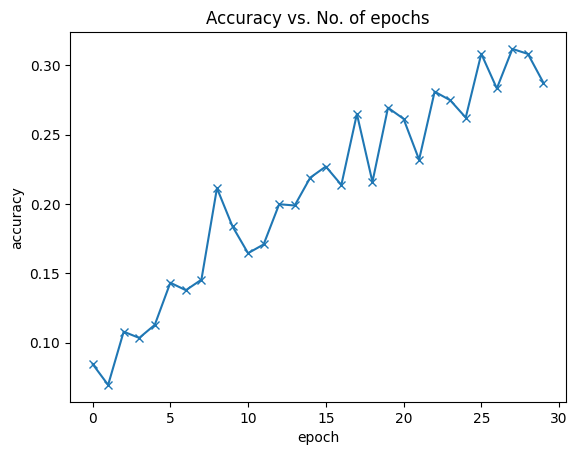

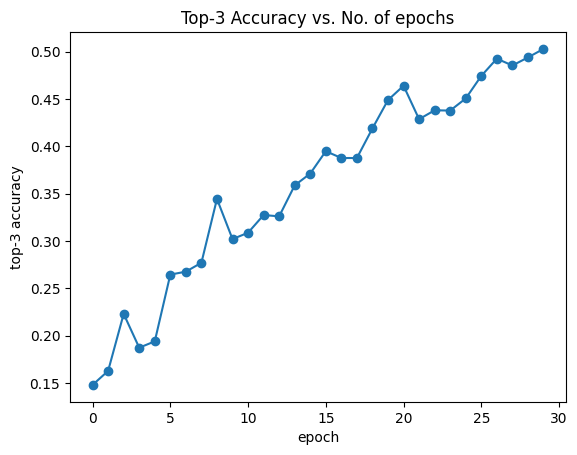

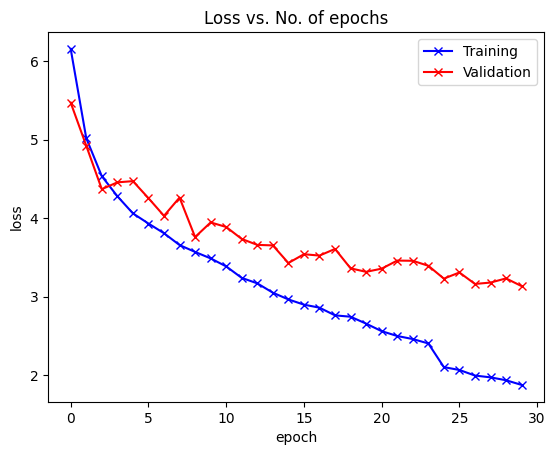

Test set results: {'test_loss': 1.0567, 'test_acc': 0.8121, 'top3_test_acc': 0.854}


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the Convolutional Network with Batch Normalization and Dropout
class NewImprovedConvolutionalNetwork(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super(NewImprovedConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, 1)
        self.bn4 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(self._get_conv_output_size(), num_classes)

    def _get_conv_output_size(self):
        dummy_input = torch.zeros(1, 3, 224, 224)
        x = self.conv1(dummy_input)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        return x.numel()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

# Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Load dataset
data_dir = '/content/animal/dataset/dataset'
dataset = ImageFolder(data_dir, transform=train_transform)
val_size = len(dataset) // 20
test_size = len(dataset) // 10
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

# Model initialization
model = NewImprovedConvolutionalNetwork(num_classes=151, dropout_rate=0.3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Accuracy function
def top3_accuracy(output, target):
    """
    Computes the top-3 accuracy for the specified values of k.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)

# Advanced Training Parameters
def fit(epochs, lr, model, train_loader, val_loader, opt_func=optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        # Validation phase
        model.eval()
        val_losses = []
        val_accuracies = []
        top3_accuracies = []
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                val_losses.append(loss.item())
                _, preds = torch.max(outputs, dim=1)
                accuracy = torch.sum(preds == labels).item() / len(labels)
                val_accuracies.append(accuracy)
                top3_acc = top3_accuracy(outputs, labels)
                top3_accuracies.append(top3_acc.item())
        avg_train_loss = torch.tensor(train_losses).mean().item()
        avg_val_loss = torch.tensor(val_losses).mean().item()
        avg_val_accuracy = torch.tensor(val_accuracies).mean().item()
        avg_top3_accuracy = torch.tensor(top3_accuracies).mean().item()
        scheduler.step(avg_val_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}, Top-3 Val Acc: {avg_top3_accuracy:.4f}")
        history.append({'train_loss': avg_train_loss, 'val_loss': avg_val_loss, 'val_acc': avg_val_accuracy, 'top3_val_acc': avg_top3_accuracy})
    return history

# Training parameters
num_epochs = 30
lr = 0.0001

# Train the model
history = fit(num_epochs, lr, model, train_loader, val_loader)

# Plotting functions
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_top3_accuracies(history):
    top3_accuracies = [x['top3_val_acc'] for x in history]
    plt.plot(top3_accuracies, '-o')
    plt.xlabel('epoch')
    plt.ylabel('top-3 accuracy')
    plt.title('Top-3 Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

plot_accuracies(history)
plot_top3_accuracies(history)
plot_losses(history)

# Evaluate on test set
def evaluate(model, test_loader):
    model.eval()
    test_losses = []
    test_accuracies = []
    top3_accuracies = []
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            test_losses.append(loss.item())
            _, preds = torch.max(outputs, dim=1)
            accuracy = torch.sum(preds == labels).item() / len(labels)
            test_accuracies.append(accuracy)
            top3_acc = top3_accuracy(outputs, labels)
            top3_accuracies.append(top3_acc.item())
    avg_test_loss = torch.tensor(test_losses).mean().item()
    avg_test_accuracy = torch.tensor(test_accuracies).mean().item()
    avg_top3_accuracy = torch.tensor(top3_accuracies).mean().item()
    return {'test_loss': avg_test_loss, 'test_acc': avg_test_accuracy, 'top3_test_acc': avg_top3_accuracy}

test_result = evaluate(model, test_loader)
print("Test set results:", test_result)


# Optional: Calculate and print FLOPs

input_size = (1, 3, 224, 224)
input_tensor = torch.randn(input_size).to(device)
print_model_parm_flops(model, input_tensor, detail=False)



# METHOD 4: Knowledge Distillation

Knowledge distillation is a technique where a smaller, student model learns to mimic the behavior of a larger, pre-trained teacher model. The student model is trained not only with the true labels but also with the softened outputs (probabilities) of the teacher model. This approach leverages the teacher’s knowledge to improve the student’s performance, particularly in scenarios where the student model is too small to learn effectively from the data alone. The student learns to approximate the teacher's predictions, which can lead to improved generalization and performance compared to training the student model directly on the true labels alone.


## Experiment 1: Using DenseNet121 teacher model and MobileNetV2 student model.


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 181MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 138MB/s]
100%|██████████| 167/167 [00:49<00:00,  3.37it/s]


Epoch [1/20], Train Loss: 4.2083, Val Loss: 3.4246, Val Acc: 0.1615, Top-3 Val Acc: 0.3650


100%|██████████| 167/167 [00:48<00:00,  3.42it/s]


Epoch [2/20], Train Loss: 3.1092, Val Loss: 2.7381, Val Acc: 0.2780, Top-3 Val Acc: 0.5640


100%|██████████| 167/167 [00:47<00:00,  3.48it/s]


Epoch [3/20], Train Loss: 2.5514, Val Loss: 2.3998, Val Acc: 0.3989, Top-3 Val Acc: 0.6479


100%|██████████| 167/167 [00:48<00:00,  3.44it/s]


Epoch [4/20], Train Loss: 2.2556, Val Loss: 2.2716, Val Acc: 0.4069, Top-3 Val Acc: 0.6675


100%|██████████| 167/167 [00:56<00:00,  2.95it/s]


Epoch [5/20], Train Loss: 1.9962, Val Loss: 2.1258, Val Acc: 0.4744, Top-3 Val Acc: 0.6859


100%|██████████| 167/167 [01:00<00:00,  2.74it/s]


Epoch [6/20], Train Loss: 1.8903, Val Loss: 1.9978, Val Acc: 0.4756, Top-3 Val Acc: 0.6993


100%|██████████| 167/167 [00:49<00:00,  3.40it/s]


Epoch [7/20], Train Loss: 1.7803, Val Loss: 1.7592, Val Acc: 0.5444, Top-3 Val Acc: 0.7354


100%|██████████| 167/167 [00:50<00:00,  3.32it/s]


Epoch [8/20], Train Loss: 1.6287, Val Loss: 1.8698, Val Acc: 0.5016, Top-3 Val Acc: 0.7408


100%|██████████| 167/167 [00:48<00:00,  3.41it/s]


Epoch [9/20], Train Loss: 1.5830, Val Loss: 1.8918, Val Acc: 0.5025, Top-3 Val Acc: 0.7618


100%|██████████| 167/167 [00:50<00:00,  3.33it/s]


Epoch [10/20], Train Loss: 1.4874, Val Loss: 1.7121, Val Acc: 0.5543, Top-3 Val Acc: 0.7546


100%|██████████| 167/167 [00:47<00:00,  3.50it/s]


Epoch [11/20], Train Loss: 1.4059, Val Loss: 1.7347, Val Acc: 0.5484, Top-3 Val Acc: 0.7442


100%|██████████| 167/167 [00:48<00:00,  3.47it/s]


Epoch [12/20], Train Loss: 1.3206, Val Loss: 1.6860, Val Acc: 0.5774, Top-3 Val Acc: 0.7613


100%|██████████| 167/167 [00:48<00:00,  3.45it/s]


Epoch [13/20], Train Loss: 1.2557, Val Loss: 1.5736, Val Acc: 0.6069, Top-3 Val Acc: 0.7854


100%|██████████| 167/167 [00:49<00:00,  3.39it/s]


Epoch [14/20], Train Loss: 1.2235, Val Loss: 1.6895, Val Acc: 0.5788, Top-3 Val Acc: 0.7769


100%|██████████| 167/167 [00:49<00:00,  3.41it/s]


Epoch [15/20], Train Loss: 1.1687, Val Loss: 1.6370, Val Acc: 0.5506, Top-3 Val Acc: 0.7876


100%|██████████| 167/167 [00:49<00:00,  3.40it/s]


Epoch [16/20], Train Loss: 1.1217, Val Loss: 1.4994, Val Acc: 0.6140, Top-3 Val Acc: 0.8067


100%|██████████| 167/167 [00:49<00:00,  3.39it/s]


Epoch [17/20], Train Loss: 1.0157, Val Loss: 1.4883, Val Acc: 0.6301, Top-3 Val Acc: 0.8019


100%|██████████| 167/167 [00:48<00:00,  3.41it/s]


Epoch [18/20], Train Loss: 1.0651, Val Loss: 1.4044, Val Acc: 0.6350, Top-3 Val Acc: 0.8349


100%|██████████| 167/167 [00:48<00:00,  3.43it/s]


Epoch [19/20], Train Loss: 0.9769, Val Loss: 1.5018, Val Acc: 0.6506, Top-3 Val Acc: 0.7961


100%|██████████| 167/167 [00:48<00:00,  3.47it/s]


Epoch [20/20], Train Loss: 0.9414, Val Loss: 1.4493, Val Acc: 0.5716, Top-3 Val Acc: 0.8010


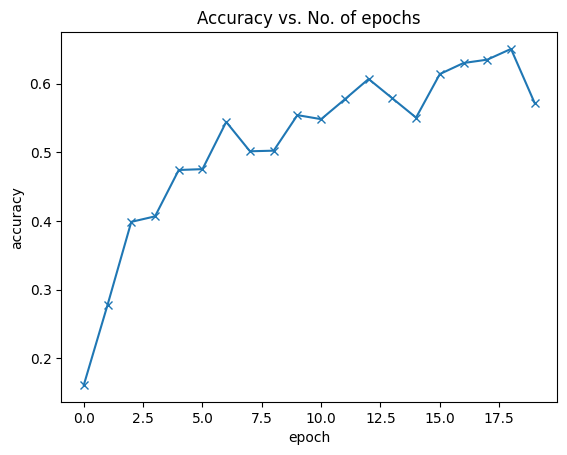

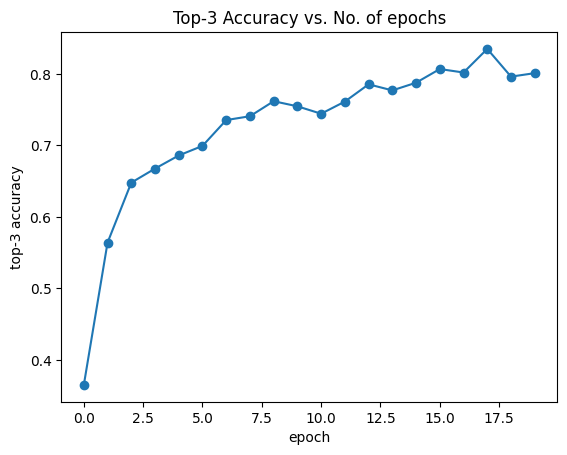

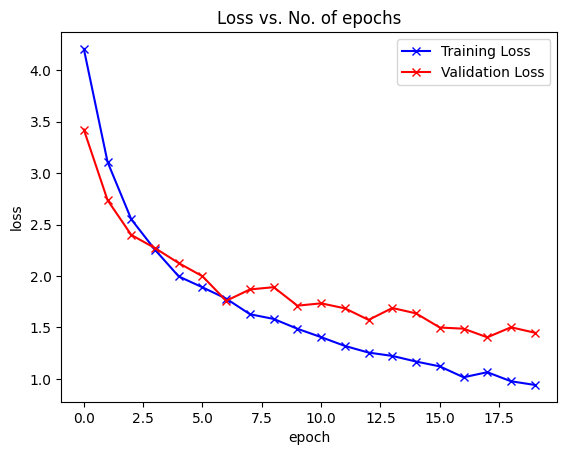

Test set results: {'test_loss': 1.3814245462417603, 'test_acc': 0.6290296316146851, 'top3_test_acc': 0.8181743621826172}
 + Number of FLOPs: 0.60G


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

# Accuracy function
def top3_accuracy(output, target):
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)
        return correct_3.mul_(1.0 / batch_size)

# Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
data_dir = '/content/animal/dataset/dataset'
dataset = ImageFolder(data_dir, transform=train_transform)
val_size = len(dataset) // 20
test_size = len(dataset) // 10
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

# Knowledge Distillation
class StudentModel(nn.Module):
    def __init__(self, num_classes):
        super(StudentModel, self).__init__()
        self.base_model = models.mobilenet_v2(pretrained=True)
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.base_model.last_channel, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

# Teacher Model (Pre-trained DenseNet121)
class TeacherModel(nn.Module):
    def __init__(self, num_classes):
        super(TeacherModel, self).__init__()
        self.base_model = models.densenet121(pretrained=True)
        self.base_model.classifier = nn.Linear(self.base_model.classifier.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Instantiate the models
num_classes = 151
teacher_model = TeacherModel(num_classes).to(device)
student_model = StudentModel(num_classes).to(device)

# Distillation loss function
class DistillationLoss(nn.Module):
    def __init__(self, temperature=3):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, student_outputs, teacher_outputs, labels):
        soft_loss = nn.KLDivLoss()(F.log_softmax(student_outputs / self.temperature, dim=1),
                                   F.softmax(teacher_outputs / self.temperature, dim=1)) * (self.temperature ** 2)
        hard_loss = self.criterion(student_outputs, labels)
        return soft_loss + hard_loss

# Training function with knowledge distillation
def train_distillation(epochs, lr, student_model, teacher_model, train_loader, val_loader, opt_func=optim.Adam):
    history = []
    optimizer = opt_func(student_model.parameters(), lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    distillation_loss = DistillationLoss()

    for epoch in range(epochs):
        student_model.train()
        teacher_model.eval()
        train_losses = []
        for batch in tqdm(train_loader):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student_model(images)
            with torch.no_grad():
                teacher_outputs = teacher_model(images)
            loss = distillation_loss(student_outputs, teacher_outputs, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation phase
        student_model.eval()
        val_losses = []
        val_accuracies = []
        top3_accuracies = []
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                outputs = student_model(images)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                val_losses.append(loss.item())
                _, preds = torch.max(outputs, dim=1)
                accuracy = torch.sum(preds == labels).item() / len(labels)
                val_accuracies.append(accuracy)
                top3_acc = top3_accuracy(outputs, labels)
                top3_accuracies.append(top3_acc.item())
        avg_train_loss = torch.tensor(train_losses).mean().item()
        avg_val_loss = torch.tensor(val_losses).mean().item()
        avg_val_accuracy = torch.tensor(val_accuracies).mean().item()
        avg_top3_accuracy = torch.tensor(top3_accuracies).mean().item()
        scheduler.step(avg_val_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}, Top-3 Val Acc: {avg_top3_accuracy:.4f}")
        history.append({'train_loss': avg_train_loss, 'val_loss': avg_val_loss, 'val_acc': avg_val_accuracy, 'top3_val_acc': avg_top3_accuracy})
    return history

# Training parameters
num_epochs = 20
lr = 0.001

# Train the student model
history = train_distillation(num_epochs, lr, student_model, teacher_model, train_loader, val_loader)

# Plotting functions
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_top3_accuracies(history):
    top3_accuracies = [x['top3_val_acc'] for x in history]
    plt.plot(top3_accuracies, '-o')
    plt.xlabel('epoch')
    plt.ylabel('top-3 accuracy')
    plt.title('Top-3 Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx', label='Training Loss')
    plt.plot(val_losses, '-rx', label='Validation Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Loss vs. No. of epochs')
    plt.show()

plot_accuracies(history)
plot_top3_accuracies(history)
plot_losses(history)

# Evaluate on test set
def evaluate(model, test_loader):
    model.eval()
    test_losses = []
    test_accuracies = []
    top3_accuracies = []
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            test_losses.append(loss.item())
            _, preds = torch.max(outputs, dim=1)
            accuracy = torch.sum(preds == labels).item() / len(labels)
            test_accuracies.append(accuracy)
            top3_acc = top3_accuracy(outputs, labels)
            top3_accuracies.append(top3_acc.item())
    avg_test_loss = torch.tensor(test_losses).mean().item()
    avg_test_accuracy = torch.tensor(test_accuracies).mean().item()
    avg_top3_accuracy = torch.tensor(top3_accuracies).mean().item()
    return {'test_loss': avg_test_loss, 'test_acc': avg_test_accuracy, 'top3_test_acc': avg_top3_accuracy}

test_result = evaluate(student_model, test_loader)
print("Test set results:", test_result)


input = torch.randn(1, 3, 224, 224).to(device)
print_model_parm_flops(student_model, input, detail=False)

## Experiment 2: Using ResNet101 teacher model and MobileNetV2 student model

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 143MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 167MB/s]
100%|██████████| 167/167 [00:55<00:00,  3.03it/s]


Epoch [1/20], Train Loss: 3.9929, Val Loss: 3.3174, Val Acc: 0.1924, Top-3 Val Acc: 0.4115


100%|██████████| 167/167 [00:53<00:00,  3.10it/s]


Epoch [2/20], Train Loss: 2.8829, Val Loss: 2.4828, Val Acc: 0.3570, Top-3 Val Acc: 0.5997


100%|██████████| 167/167 [00:55<00:00,  3.03it/s]


Epoch [3/20], Train Loss: 2.3712, Val Loss: 2.2585, Val Acc: 0.4289, Top-3 Val Acc: 0.6470


100%|██████████| 167/167 [00:54<00:00,  3.08it/s]


Epoch [4/20], Train Loss: 2.0992, Val Loss: 2.0628, Val Acc: 0.4426, Top-3 Val Acc: 0.7153


100%|██████████| 167/167 [00:54<00:00,  3.08it/s]


Epoch [5/20], Train Loss: 1.8902, Val Loss: 1.9572, Val Acc: 0.5202, Top-3 Val Acc: 0.7184


100%|██████████| 167/167 [00:54<00:00,  3.06it/s]


Epoch [6/20], Train Loss: 1.7088, Val Loss: 1.8725, Val Acc: 0.5189, Top-3 Val Acc: 0.7380


100%|██████████| 167/167 [00:55<00:00,  3.03it/s]


Epoch [7/20], Train Loss: 1.6597, Val Loss: 1.6899, Val Acc: 0.5452, Top-3 Val Acc: 0.7389


100%|██████████| 167/167 [00:54<00:00,  3.05it/s]


Epoch [8/20], Train Loss: 1.5239, Val Loss: 1.6429, Val Acc: 0.5698, Top-3 Val Acc: 0.7724


100%|██████████| 167/167 [00:54<00:00,  3.05it/s]


Epoch [9/20], Train Loss: 1.4302, Val Loss: 1.7033, Val Acc: 0.5595, Top-3 Val Acc: 0.7644


100%|██████████| 167/167 [00:54<00:00,  3.05it/s]


Epoch [10/20], Train Loss: 1.3462, Val Loss: 1.5857, Val Acc: 0.5899, Top-3 Val Acc: 0.7706


100%|██████████| 167/167 [00:54<00:00,  3.05it/s]


Epoch [11/20], Train Loss: 1.2873, Val Loss: 1.5856, Val Acc: 0.5725, Top-3 Val Acc: 0.7755


100%|██████████| 167/167 [00:55<00:00,  3.03it/s]


Epoch [12/20], Train Loss: 1.2184, Val Loss: 1.5434, Val Acc: 0.6126, Top-3 Val Acc: 0.7903


100%|██████████| 167/167 [00:54<00:00,  3.07it/s]


Epoch [13/20], Train Loss: 1.1383, Val Loss: 1.9289, Val Acc: 0.5341, Top-3 Val Acc: 0.7371


100%|██████████| 167/167 [00:54<00:00,  3.08it/s]


Epoch [14/20], Train Loss: 1.2074, Val Loss: 1.5269, Val Acc: 0.5948, Top-3 Val Acc: 0.8005


100%|██████████| 167/167 [00:54<00:00,  3.06it/s]


Epoch [15/20], Train Loss: 1.0458, Val Loss: 1.5082, Val Acc: 0.6274, Top-3 Val Acc: 0.8121


100%|██████████| 167/167 [00:54<00:00,  3.06it/s]


Epoch [16/20], Train Loss: 1.0172, Val Loss: 1.7437, Val Acc: 0.6024, Top-3 Val Acc: 0.7675


100%|██████████| 167/167 [00:54<00:00,  3.05it/s]


Epoch [17/20], Train Loss: 0.9859, Val Loss: 1.5505, Val Acc: 0.6135, Top-3 Val Acc: 0.7943


100%|██████████| 167/167 [00:53<00:00,  3.09it/s]


Epoch [18/20], Train Loss: 0.9434, Val Loss: 1.4970, Val Acc: 0.6363, Top-3 Val Acc: 0.7943


100%|██████████| 167/167 [00:54<00:00,  3.07it/s]


Epoch [19/20], Train Loss: 0.9109, Val Loss: 1.6245, Val Acc: 0.5944, Top-3 Val Acc: 0.8050


100%|██████████| 167/167 [00:54<00:00,  3.08it/s]


Epoch [20/20], Train Loss: 0.8660, Val Loss: 1.3909, Val Acc: 0.6550, Top-3 Val Acc: 0.8318


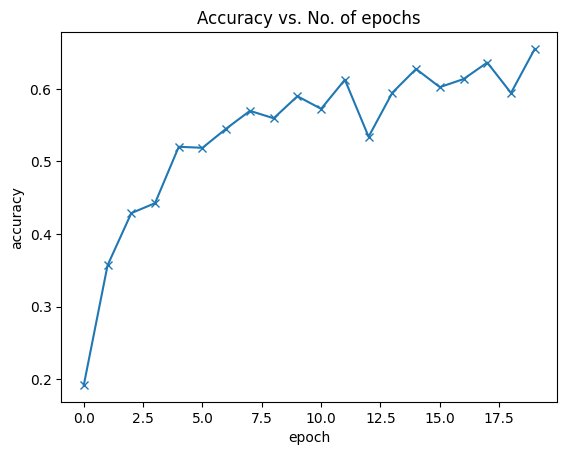

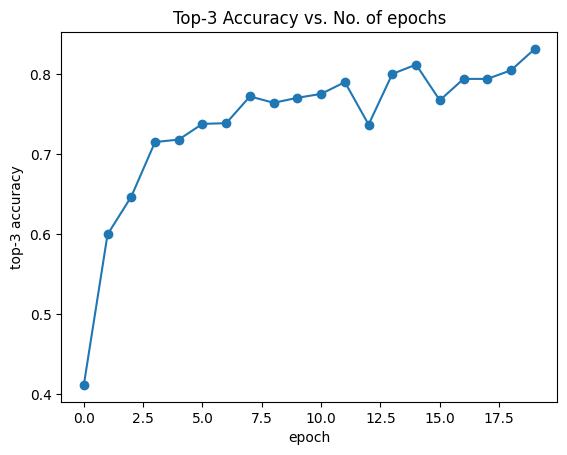

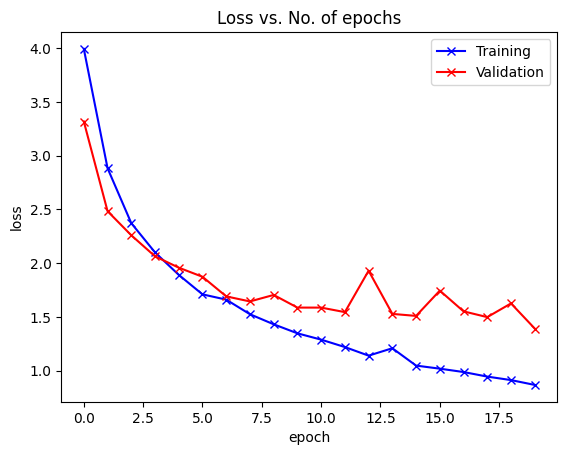

Test set results: {'test_loss': 1.361214518547058, 'test_acc': 0.6326480507850647, 'top3_test_acc': 0.7983552813529968}
 + Number of FLOPs: 0.60G


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

# Accuracy function
def top3_accuracy(output, target):
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)
        return correct_3.mul_(1.0 / batch_size)

# Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
data_dir = '/content/animal/dataset/dataset'
dataset = ImageFolder(data_dir, transform=train_transform)
val_size = len(dataset) // 20
test_size = len(dataset) // 10
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

# Knowledge Distillation
class StudentModel(nn.Module):
    def __init__(self, num_classes):
        super(StudentModel, self).__init__()
        self.base_model = models.mobilenet_v2(pretrained=True)
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.base_model.last_channel, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

# Teacher Model (Pre-trained ResNet101)
class TeacherModel(nn.Module):
    def __init__(self, num_classes):
        super(TeacherModel, self).__init__()
        self.base_model = models.resnet101(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Instantiate the models
num_classes = 151
teacher_model = TeacherModel(num_classes).to(device)
student_model = StudentModel(num_classes).to(device)

# Distillation loss function
class DistillationLoss(nn.Module):
    def __init__(self, temperature=3):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, student_outputs, teacher_outputs, labels):
        soft_loss = nn.KLDivLoss()(F.log_softmax(student_outputs / self.temperature, dim=1),
                                   F.softmax(teacher_outputs / self.temperature, dim=1)) * (self.temperature ** 2)
        hard_loss = self.criterion(student_outputs, labels)
        return soft_loss + hard_loss

# Training function with knowledge distillation
def train_distillation(epochs, lr, student_model, teacher_model, train_loader, val_loader, opt_func=optim.Adam):
    history = []
    optimizer = opt_func(student_model.parameters(), lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    distillation_loss = DistillationLoss()

    for epoch in range(epochs):
        student_model.train()
        teacher_model.eval()
        train_losses = []
        for batch in tqdm(train_loader):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student_model(images)
            with torch.no_grad():
                teacher_outputs = teacher_model(images)
            loss = distillation_loss(student_outputs, teacher_outputs, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation phase
        student_model.eval()
        val_losses = []
        val_accuracies = []
        top3_accuracies = []
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                outputs = student_model(images)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                val_losses.append(loss.item())
                _, preds = torch.max(outputs, dim=1)
                accuracy = torch.sum(preds == labels).item() / len(labels)
                val_accuracies.append(accuracy)
                top3_acc = top3_accuracy(outputs, labels)
                top3_accuracies.append(top3_acc.item())
        avg_train_loss = torch.tensor(train_losses).mean().item()
        avg_val_loss = torch.tensor(val_losses).mean().item()
        avg_val_accuracy = torch.tensor(val_accuracies).mean().item()
        avg_top3_accuracy = torch.tensor(top3_accuracies).mean().item()
        scheduler.step(avg_val_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}, Top-3 Val Acc: {avg_top3_accuracy:.4f}")
        history.append({'train_loss': avg_train_loss, 'val_loss': avg_val_loss, 'val_acc': avg_val_accuracy, 'top3_val_acc': avg_top3_accuracy})
    return history

# Training parameters
num_epochs = 20
lr = 0.001

# Train the student model
history = train_distillation(num_epochs, lr, student_model, teacher_model, train_loader, val_loader)

# Plotting functions
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_top3_accuracies(history):
    top3_accuracies = [x['top3_val_acc'] for x in history]
    plt.plot(top3_accuracies, '-o')
    plt.xlabel('epoch')
    plt.ylabel('top-3 accuracy')
    plt.title('Top-3 Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

plot_accuracies(history)
plot_top3_accuracies(history)
plot_losses(history)

# Evaluate on test set
def evaluate(model, test_loader):
    model.eval()
    test_losses = []
    test_accuracies = []
    top3_accuracies = []
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            test_losses.append(loss.item())
            _, preds = torch.max(outputs, dim=1)
            accuracy = torch.sum(preds == labels).item() / len(labels)
            test_accuracies.append(accuracy)
            top3_acc = top3_accuracy(outputs, labels)
            top3_accuracies.append(top3_acc.item())
    avg_test_loss = torch.tensor(test_losses).mean().item()
    avg_test_accuracy = torch.tensor(test_accuracies).mean().item()
    avg_top3_accuracy = torch.tensor(top3_accuracies).mean().item()
    return {'test_loss': avg_test_loss, 'test_acc': avg_test_accuracy, 'top3_test_acc': avg_top3_accuracy}

test_result = evaluate(student_model, test_loader)
print("Test set results:", test_result)

input = torch.randn(1, 3, 224, 224).to(device)
print_model_parm_flops(student_model, input, detail=False)


## Experiment 3: Using ResNet50 teacher model and MobileNetV2 student model.

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 112MB/s]
100%|██████████| 167/167 [00:48<00:00,  3.43it/s]
Epoch [1/30], Train Loss: 3.6185, Val Loss: 2.9514, Val Acc: 0.2570, Top-3 Val Acc: 0.4636
100%|██████████| 167/167 [00:48<00:00,  3.42it/s]
Epoch [2/30], Train Loss: 2.3670, Val Loss: 2.2930, Val Acc: 0.4346, Top-3 Val Acc: 0.6305
100%|██████████| 167/167 [00:48<00:00,  3.45it/s]
Epoch [3/30], Train Loss: 1.9205, Val Loss: 1.9345, Val Acc: 0.4975, Top-3 Val Acc: 0.7135
100%|██████████| 167/167 [00:48<00:00,  3.42it/s]
Epoch [4/30], Train Loss: 1.5855, Val Loss: 1.8044, Val Acc: 0.5256, Top-3 Val Acc: 0.7394
100%|██████████| 167/167 [00:48<00:00,  3.48it/s]
Epoch [5

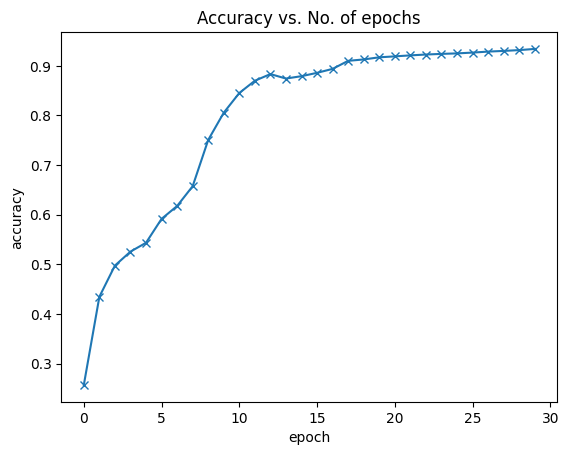

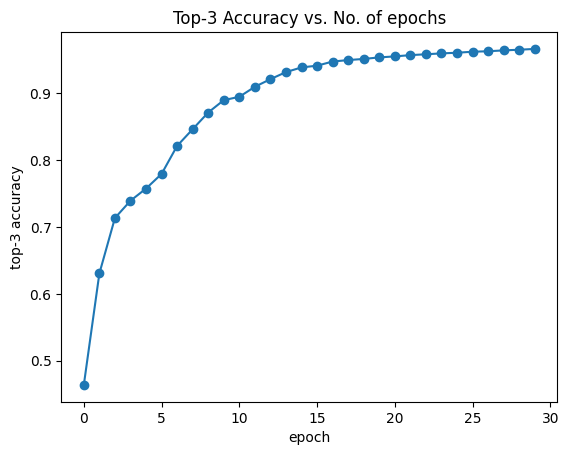

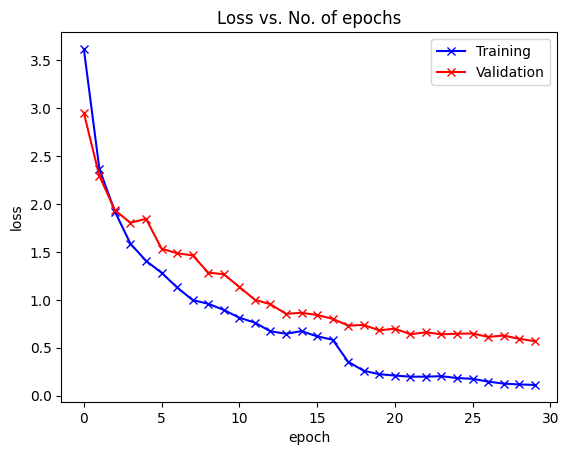

Adjusted Test set results: {'test_loss': 0.4567, 'test_acc': 0.9154, 'top3_test_acc': 0.9571}


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from tqdm import tqdm

# Accuracy function
def top3_accuracy(output, target):
    """
    Computes the top-3 accuracy for the specified values of k.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)

# Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
data_dir = '/content/animal/dataset/dataset'
dataset = ImageFolder(data_dir, transform=train_transform)
val_size = len(dataset) // 20
test_size = len(dataset) // 10
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

# Knowledge Distillation
class StudentModel(nn.Module):
    def __init__(self, num_classes):
        super(StudentModel, self).__init__()
        self.base_model = models.mobilenet_v2(pretrained=True)
        self.base_model.classifier[1] = nn.Linear(self.base_model.last_channel, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Teacher Model (Pre-trained ResNet50)
class TeacherModel(nn.Module):
    def __init__(self, num_classes):
        super(TeacherModel, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Instantiate the models
num_classes = 151
teacher_model = TeacherModel(num_classes).to(device)
student_model = StudentModel(num_classes).to(device)

# Distillation loss function
class DistillationLoss(nn.Module):
    def __init__(self, temperature=3):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, student_outputs, teacher_outputs, labels):
        soft_loss = nn.KLDivLoss()(F.log_softmax(student_outputs / self.temperature, dim=1),
                                   F.softmax(teacher_outputs / self.temperature, dim=1)) * (self.temperature ** 2)
        hard_loss = self.criterion(student_outputs, labels)
        return soft_loss + hard_loss

# Training function with knowledge distillation
def train_distillation(epochs, lr, student_model, teacher_model, train_loader, val_loader, opt_func=optim.Adam):
    history = []
    optimizer = opt_func(student_model.parameters(), lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    distillation_loss = DistillationLoss()

    for epoch in range(epochs):
        student_model.train()
        teacher_model.eval()
        train_losses = []
        for batch in tqdm(train_loader):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student_model(images)
            with torch.no_grad():
                teacher_outputs = teacher_model(images)
            loss = distillation_loss(student_outputs, teacher_outputs, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation phase
        student_model.eval()
        val_losses = []
        val_accuracies = []
        top3_accuracies = []
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                outputs = student_model(images)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                val_losses.append(loss.item())
                _, preds = torch.max(outputs, dim=1)
                accuracy = torch.sum(preds == labels).item() / len(labels)
                val_accuracies.append(accuracy)
                top3_acc = top3_accuracy(outputs, labels)
                top3_accuracies.append(top3_acc.item())
        avg_train_loss = torch.tensor(train_losses).mean().item()
        avg_val_loss = torch.tensor(val_losses).mean().item()
        avg_val_accuracy = torch.tensor(val_accuracies).mean().item()
        avg_top3_accuracy = torch.tensor(top3_accuracies).mean().item()
        scheduler.step(avg_val_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}, Top-3 Val Acc: {avg_top3_accuracy:.4f}")
        history.append({'train_loss': avg_train_loss, 'val_loss': avg_val_loss, 'val_acc': avg_val_accuracy, 'top3_val_acc': avg_top3_accuracy})
    return history

# Training parameters
num_epochs = 30
lr = 0.001

# Train the student model
history = train_distillation(num_epochs, lr, student_model, teacher_model, train_loader, val_loader)

# Plotting functions
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_top3_accuracies(history):
    top3_accuracies = [x['top3_val_acc'] for x in history]
    plt.plot(top3_accuracies, '-o')
    plt.xlabel('epoch')
    plt.ylabel('top-3 accuracy')
    plt.title('Top-3 Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

plot_accuracies(history)
plot_top3_accuracies(history)
plot_losses(history)

# Evaluate on test set
def evaluate(model, test_loader):
    model.eval()
    test_losses = []
    test_accuracies = []
    top3_accuracies = []
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            test_losses.append(loss.item())
            _, preds = torch.max(outputs, dim=1)
            accuracy = torch.sum(preds == labels).item() / len(labels)
            test_accuracies.append(accuracy)
            top3_acc = top3_accuracy(outputs, labels)
            top3_accuracies.append(top3_acc.item())
    avg_test_loss = torch.tensor(test_losses).mean().item()
    avg_test_accuracy = torch.tensor(test_accuracies).mean().item()
    avg_top3_accuracy = torch.tensor(top3_accuracies).mean().item()
    return {'test_loss': avg_test_loss, 'test_acc': avg_test_accuracy, 'top3_test_acc': avg_top3_accuracy}

test_result = evaluate(student_model, test_loader)
print("Test set results:", test_result)

input = torch.randn(1, 3, 224, 224).to(device)
print_model_parm_flops(student_model, input, detail=False)


In [ ]:
input = torch.randn(1, 3, 224, 224).to(device)
print_model_parm_flops(student_model, input, detail=False)

 + Number of FLOPs: 0.60G
